In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb



In [2]:
# Display setting to better visualize notebook
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',10)
pd.set_option('display.width',1000)

In [3]:
# Read Aggregated  data
df = pd.read_csv('New_features.csv')

In [4]:
df.shape

(5410, 13)

In [5]:
df.head()

,Provider,IP_average_claim_duration,OP_average_claim_duration,PotentialFraud,IP_Claims_Total,OP_Claims_Total,IP_Averagedaysinhospital,IPAnnualDeductibleAmt,OPAnnualDeductibleAmt,IP_total_diagnosis,OP_total_diagnosis,IP_total_procedures,OP_total_procedures
0,PRV51001,5.0,1.0,No,97000.0,7640.0,5.0,890.0,475.0,36.0,44.0,3.0,0.0
1,PRV51003,5.0,2.0,Yes,573000.0,32670.0,5.0,823.0,665.0,503.0,190.0,48.0,0.0
2,PRV51004,0.0,1.0,No,0.0,52170.0,0.0,454.0,601.0,0.0,385.0,0.0,0.0
3,PRV51005,0.0,1.0,Yes,0.0,280910.0,0.0,399.0,476.0,0.0,3016.0,0.0,0.0
4,PRV51007,5.0,1.0,No,19000.0,14710.0,5.0,424.0,431.0,22.0,193.0,1.0,0.0


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.9390
Precision: 0.8302
Recall: 0.4356
F1-score: 0.5714
ROC-AUC: 0.9591
Confusion Matrix:
 [[972   9]
 [ 57  44]]


C:\Docs\New folder\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


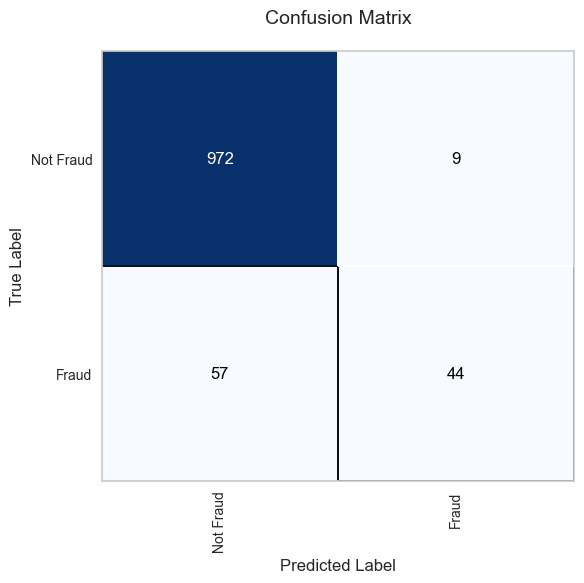

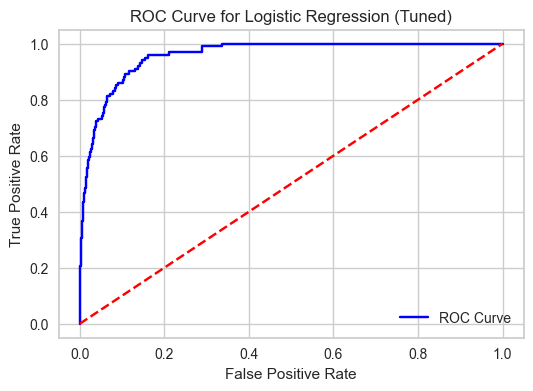

In [6]:
# Logistic Regression model 
# Drop non-feature columns
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Define hyperparameter grid
param_grid = [
    # Grid for 'liblinear' solver, which supports both 'l1' and 'l2' penalties
    {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'solver': ['liblinear'],  # Solver options
        'class_weight': ['balanced', None],  # Handling class imbalance
        'penalty': ['l1', 'l2']  # Regularization type
    },
    # Grid for 'lbfgs' solver, which supports only 'l2' penalty
    {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'solver': ['lbfgs'],  # Solver options
        'class_weight': ['balanced', None],  # Handling class imbalance
        'penalty': ['l2']  # Regularization type
    }
]

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the model with best parameters
best_log_reg = grid_search.best_estimator_

# Predictions
y_pred = best_log_reg.predict(X_test)
y_prob = best_log_reg.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Visualize Confusion Matrix using Yellowbrick
# Explicitly fit the model before visualization
from yellowbrick.classifier import ConfusionMatrix
best_log_reg.fit(X_train, y_train)

# Create the confusion matrix visualizer
plt.figure(figsize=(6, 6))
cm = ConfusionMatrix(best_log_reg, classes=['Not Fraud', 'Fraud'], cmap='Blues', percent=False)
cm.score(X_test, y_test)

# Set title and labels
cm.ax.set_title('Confusion Matrix', fontsize=14, pad=20)
cm.ax.set_xlabel('Predicted Label', fontsize=12)
cm.ax.set_ylabel('True Label', fontsize=12)
cm.ax.tick_params(axis='both', which='major', labelsize=10)

# Display the plot
plt.tight_layout()
plt.show()

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression (Tuned)')
plt.legend(loc='lower right')
plt.show()

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8669
Precision: 0.4009
Recall: 0.8614
F1-score: 0.5472
ROC-AUC: 0.9368
Confusion Matrix:
 [[851 130]
 [ 14  87]]


C:\Docs\New folder\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


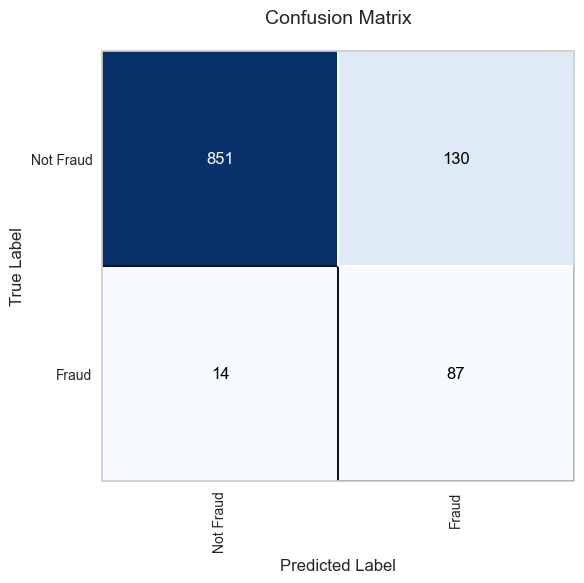

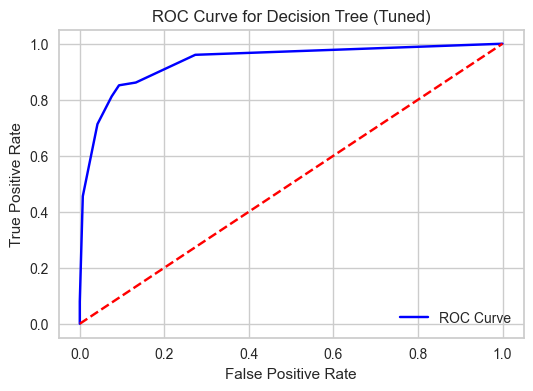

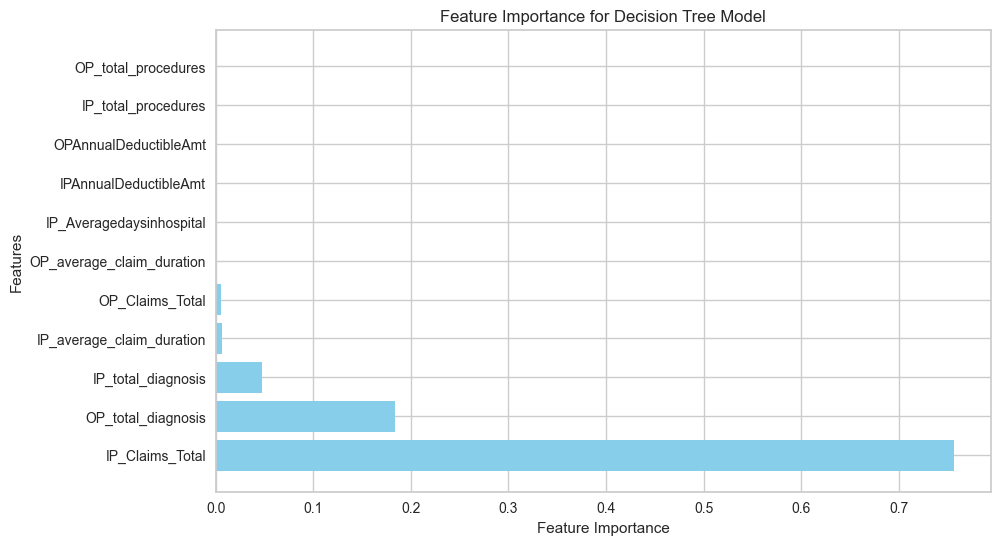

In [7]:
# 2. Decision tree model

# Drop non-feature columns
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Define hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [3, 5, 10, 15, 20],  # Depth of tree
    'min_samples_split': [2, 5, 10],  # Minimum samples for a split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples for leaf
    'class_weight': ['balanced', None]  # Handle class imbalance
}

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the model with best parameters
best_dt_model = grid_search.best_estimator_

# Predictions
y_pred = best_dt_model.predict(X_test)
y_prob = best_dt_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Visualize Confusion Matrix using Yellowbrick
# Explicitly fit the model before visualization
best_dt_model.fit(X_train, y_train)

# Create the confusion matrix visualizer
plt.figure(figsize=(6, 6))
cm = ConfusionMatrix(best_dt_model, classes=['Not Fraud', 'Fraud'], cmap='Blues', percent=False)
cm.score(X_test, y_test)

# Set title and labels
cm.ax.set_title('Confusion Matrix', fontsize=14, pad=20)
cm.ax.set_xlabel('Predicted Label', fontsize=12)
cm.ax.set_ylabel('True Label', fontsize=12)
cm.ax.tick_params(axis='both', which='major', labelsize=10)

# Display the plot
plt.tight_layout()
plt.show()

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree (Tuned)')
plt.legend(loc='lower right')
plt.show()

# Feature Importance
feature_importances = best_dt_model.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Decision Tree Model')
plt.show()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Accuracy: 0.9436
Precision: 0.7500
Recall: 0.5941
F1-score: 0.6630
ROC-AUC: 0.9567
Confusion Matrix:
 [[961  20]
 [ 41  60]]


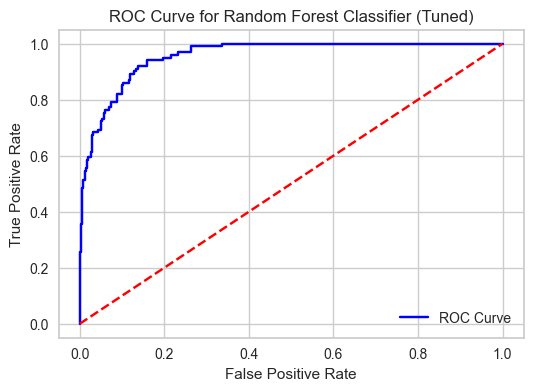

In [8]:
# 3. Random Forest model 

# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
    'classifier__class_weight': ['balanced', None]  # Handling class imbalance
}

# Create a pipeline with preprocessor and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Train the model with best parameters
best_rf_model = grid_search.best_estimator_

# Make Predictions and Evaluate the Model
y_pred = best_rf_model.predict(X_test)
y_prob = best_rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Evaluate model performance with different classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier (Tuned)')
plt.legend(loc='lower right')
plt.show()

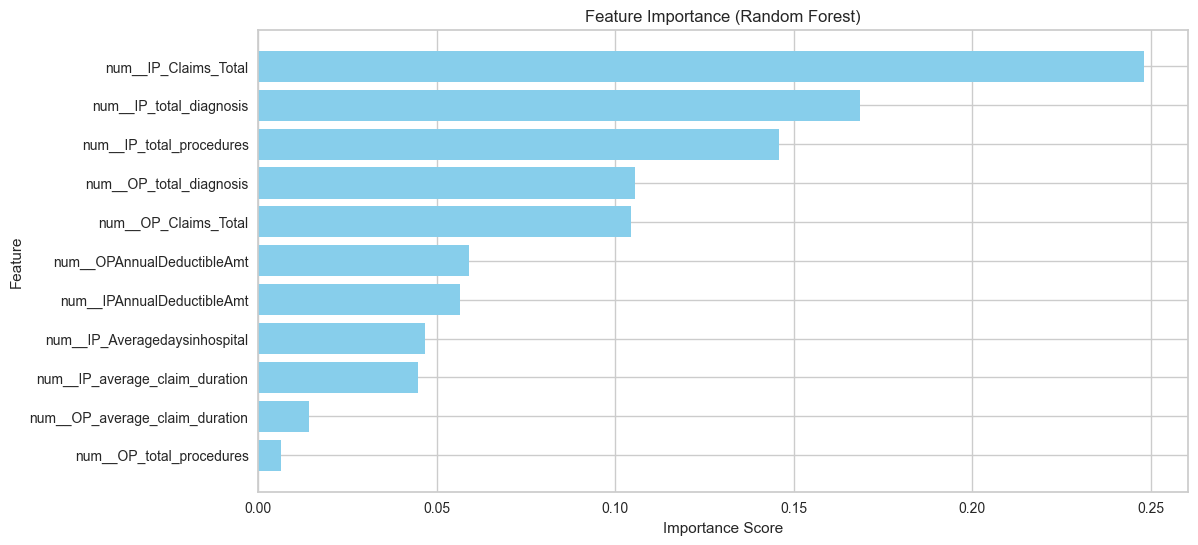

In [9]:
# Extract the best trained Random Forest model from the pipeline
best_rf = best_rf_model.named_steps['classifier']

# Get feature importance values
feature_importance = best_rf.feature_importances_

# Get feature names after preprocessing (One-Hot Encoding adds new feature names)
feature_names = best_rf_model.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort features by importance in descending order
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Docs\New folder\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Accuracy: 0.8734
Precision: 0.4182
Recall: 0.9109
F1-score: 0.5732
ROC-AUC: 0.9612
Confusion Matrix:
 [[853 128]
 [  9  92]]


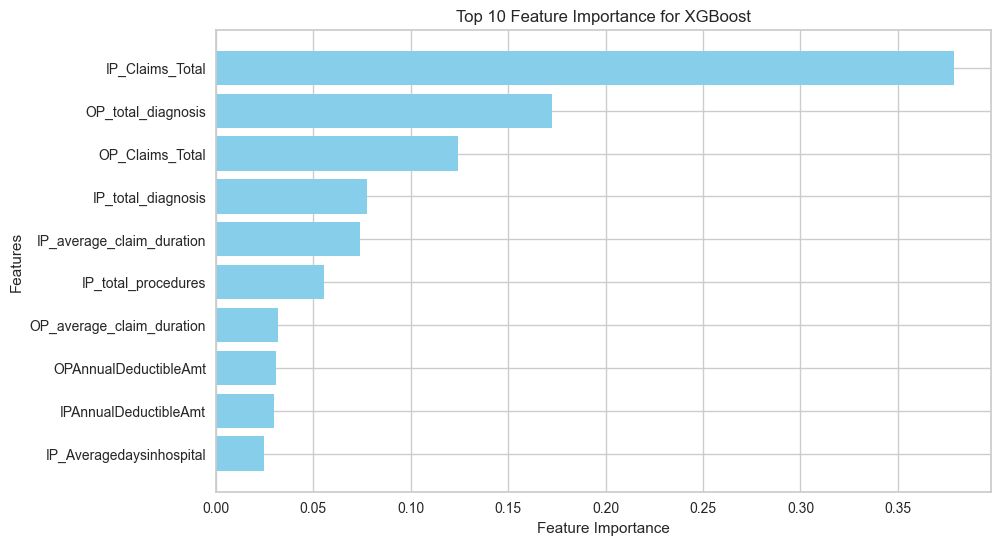

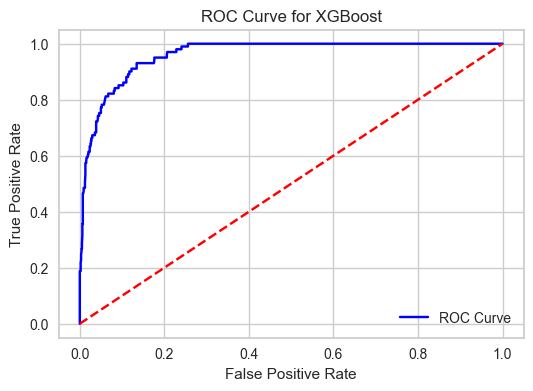

In [10]:
# 4. XG Boost model
# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the preprocessor and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)

# Get numeric feature names
numeric_feature_names = numeric_features.tolist()

# Get categorical feature names from OneHotEncoder
one_hot_encoder = preprocessor.transformers_[1][1].named_steps['encoder']

# Fit the OneHotEncoder before getting feature names
one_hot_encoder.fit(X_train[categorical_features])

# Get the one hot encoded feature names
one_hot_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)

# Combine all feature names
all_feature_names = numeric_feature_names + list(one_hot_feature_names)

# Calculate class weight for XGBoost
fraud_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]  # No Fraud / Fraud

# Create and train XGBoost model pipeline with scale_pos_weight
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=fraud_ratio, use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter grid
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
}

# Create pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters after hyperparameter tuning
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator (tuned model)
best_model = grid_search.best_estimator_

# Make Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Retrieve feature importances from XGBoost
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort and visualize the top 10 features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
top_10_features = feature_importance_df.head(10)
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importance for XGBoost')
plt.gca().invert_yaxis()
plt.show()

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# 5. LightGBM model 

# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Replace NaN and Inf values
X_train = X_train.fillna(0).replace([np.inf, -np.inf], 0)
X_test = X_test.fillna(0).replace([np.inf, -np.inf], 0)

# Define LightGBM model
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 300, 500],  # Number of trees
    'classifier__learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'classifier__max_depth': [5, 10, 15],  # Tree depth
    'classifier__num_leaves': [20, 40, 60],  # Number of leaves per tree
    'classifier__min_child_samples': [10, 20, 30],  # Minimum samples per leaf
    'classifier__subsample': [0.8, 1.0],  # Fraction of data used per iteration
    'classifier__colsample_bytree': [0.8, 1.0]  # Fraction of features used per tree
}

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgbm)
])

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model
best_lgbm_model = grid_search.best_estimator_

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Make Predictions and Evaluate the Model
y_pred = best_lgbm_model.predict(X_test)
y_prob = best_lgbm_model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC AUC

# Evaluate model performance with different classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM (Tuned)')
plt.legend(loc='lower right')
plt.show()

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


In [ ]:
# 6. CAT Boost model 
# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine transformations (CatBoost handles categorical features natively, so we skip encoding)
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
], remainder='passthrough')  # Pass categorical features as-is

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute class weights for imbalanced data
class_weights = {0: len(y) / (2 * sum(y == 0)), 1: len(y) / (2 * sum(y == 1))}

# Initialize CatBoost model
cat_model = CatBoostClassifier(loss_function='Logloss', random_state=42, class_weights=class_weights, verbose=0)

# Define hyperparameter grid
param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__depth': [4, 6, 8],
    'classifier__iterations': [200, 500],
    'classifier__l2_leaf_reg': [1, 3, 5]
}

# Create pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', cat_model)
])

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters from tuning
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator (tuned model)
best_model = grid_search.best_estimator_

# Make Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Retrieve feature importances
feature_importances = best_model.named_steps['classifier'].get_feature_importance()
feature_names = numeric_features.tolist() + categorical_features.tolist()  # Use original feature names

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
top_10_features = feature_importance_df.head(10)
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importance for CatBoost')
plt.gca().invert_yaxis()
plt.show()

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost Model')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Models Performance comparison 
# Define features and target variable
# Define features and target variable
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Define models with class_weight='balanced' where applicable
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=len(y) / (2 * sum(y == 1))),  # Adjust class weight
    "LightGBM": lgb.LGBMClassifier(random_state=42, class_weight='balanced'),  # Adjust class weight
    "CatBoost": cb.CatBoostClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, loss_function='Logloss', verbose=0, random_state=42, scale_pos_weight=len(y) / (2 * sum(y == 1)))  # Adjust class weight
}

# To store evaluation results
metrics = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": [], "ROC-AUC": []}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Append metrics to results
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1-Score"].append(f1)
    metrics["ROC-AUC"].append(roc_auc)

# Convert metrics to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)

# Plot comparison of models with a larger figure size
fig, ax = plt.subplots(2, 1, figsize=(12, 8))  

# Bar chart for comparison of evaluation metrics
metrics_df.set_index("Model").plot(kind="bar", ax=ax[0], color=['blue', 'orange', 'green', 'red', 'purple'], figsize=(12, 10))
ax[0].set_title('Model Performance Comparison', fontsize=10)
ax[0].set_ylabel('Score', fontsize=14)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Model', fontsize=14)
ax[0].tick_params(axis='x', rotation=45)  # Rotate x labels for better visibility
ax[0].legend(loc='lower right', fontsize=12)

# ROC Curve Comparison
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax[1].plot(fpr, tpr, label=f'{name} ROC Curve')

ax[1].plot([0, 1], [0, 1], color='red', linestyle='--') 
ax[1].set_xlabel('False Positive Rate', fontsize=10)
ax[1].set_ylabel('True Positive Rate', fontsize=8)
ax[1].set_title('ROC Curve Comparison', fontsize=10)
ax[1].legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Visualize the Class Prediction Error for all models using Yellowbrick
#CatBoostClassifier is not fully compatible with Yellowbrick's ClassPredictionError visualizer.
# For XGBoost and LightGBM, the imbalance handling is done by setting scale_pos_weight appropriately.
from yellowbrick.classifier import ClassPredictionError
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Define models with class_weight='balanced' where applicable
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=len(y) / (2 * sum(y == 1))),  # Adjust class weight
    "LightGBM": LGBMClassifier(verbose=-1, random_state=42, class_weight='balanced')  # Adjust class weight
}

# Set up the figure for visualization
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through models and plot Class Prediction Error
for i, (name, model) in enumerate(models.items()):
    visualizer = ClassPredictionError(model, ax=axes[i])  # Create the visualizer
    model.fit(X_train, y_train)  # Train model
    visualizer.fit(X_train, y_train)  # Fit visualizer
    visualizer.score(X_test, y_test)  # Evaluate on test data
    visualizer.finalize()
    axes[i].set_title(name, fontsize=14)  # Set individual plot titles

plt.tight_layout()
plt.show()

In [ ]:
# Precision-Recall Curve
# Useful when dealing with imbalanced data. Highlights trade-off between precision and recall.Evaluates imbalanced fraud detection.
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Define models with class_weight='balanced' where applicable
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=len(y) / (2 * sum(y == 1))),  # Adjust class weight
    "LightGBM": LGBMClassifier(verbose=-1, random_state=42, class_weight='balanced')  # Adjust class weight
}

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 5))

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Get probabilities for the positive class
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Fraud Detection Models")
plt.legend()
plt.show()

In [ ]:
#ROC Curve Comparison
# Shows true positive rate (TPR) vs. false positive rate (FPR). Helps visualize classification threshold effectiveness.
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define models with class_weight='balanced' where applicable
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=len(y) / (2 * sum(y == 1))),  # Adjust class weight
    "LightGBM": LGBMClassifier(verbose=-1, random_state=42, class_weight='balanced')  # Adjust class weight
}

# Plot ROC Curve Comparison
plt.figure(figsize=(8, 5))

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Get probabilities for the positive class
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Add diagonal line for random classifier (no discrimination)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [ ]:
# Feature Importance (Tree-Based Models)
# Highlights key predictors in fraud detection.
import pandas as pd
import matplotlib.pyplot as plt

# Models with class_weight='balanced'
tree_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=len(y) / (2 * sum(y == 1)))  # Adjust class weight
}

# Train the models and plot feature importance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # For three tree-based models

for i, name in enumerate(tree_models):
    model = tree_models[name]
    model.fit(X_train, y_train)  # Fit the model
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort the importances and get the feature names in the sorted order
    indices = importances.argsort()[::-1]
    features = X.columns[indices]

    # Plot the top 10 feature importances
    pd.Series(importances[indices], index=features).head(10).plot(kind='barh', ax=axes[i], color='darkblue')
    axes[i].set_title(f"{name} Feature Importance")

plt.tight_layout()
plt.show()

In [ ]:
# Model Accuracy Comparison (Bar Chart)
# Quick comparison of accuracy across models.
accuracies = {name: model.score(X_test, y_test) for name, model in models.items()}
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color="skyblue")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calibration Plot
# Measures how well predicted probabilities match actual fraud occurrence(probability reliability).
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Define models with class_weight='balanced'
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=1),  # XGBoost handles class weights differently
    "LightGBM": LGBMClassifier(verbose=-1, random_state=42, class_weight='balanced')  # LightGBM also supports class_weight='balanced'
}

plt.figure(figsize=(8, 5))

# Train and plot the calibration curves for each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Fit model
    y_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)  # Calibration curve
    plt.plot(prob_pred, prob_true, marker="o", label=name)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Line for perfect calibration
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Fraud Probability")
plt.title("Calibration Plot for Fraud Detection Models")
plt.legend()
plt.show()

In [ ]:
# Lift Curve
# Measures how much better the model performs(effectiveness) than random guessing

import numpy as np
import matplotlib.pyplot as plt

# Define models with class_weight='balanced'
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=1),  # XGBoost handles class weights differently
    "LightGBM": LGBMClassifier(verbose=-1, random_state=42, class_weight='balanced')  # LightGBM also supports class_weight='balanced'
}

plt.figure(figsize=(8, 5))

# Train and plot the lift curve for each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Fit model
    y_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1 (fraud)
    
    # Get the sorted indices of predicted probabilities
    sorted_indices = np.argsort(y_probs)[::-1]
    
    # Sort y_test and y_probs based on the sorted indices
    sorted_y_test = y_test.iloc[sorted_indices]
    sorted_probs = y_probs[sorted_indices]
    
    # Calculate the lift
    lift = np.cumsum(sorted_y_test) / np.arange(1, len(y_test) + 1)
    
    # Plot lift curve
    plt.plot(sorted_probs, lift, label=name)

plt.xlabel("Predicted Probability")
plt.ylabel("Lift")
plt.title("Lift Curve for Fraud Detection Models")
plt.legend()
plt.show()

In [ ]:
# Cumulative Gains Chart
# Shows how many fraud cases are detected at different cut-off levels.Tracks fraud detection rates.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Define models with class_weight='balanced'
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=1),  # XGBoost handles class weights differently
    "LightGBM": LGBMClassifier(verbose=-1, random_state=42, class_weight='balanced')  # LightGBM also supports class_weight='balanced'
}

plt.figure(figsize=(10, 6))

# Train and plot the cumulative gains chart for each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Fit model
    y_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1 (fraud)
    
    # Calculate the false positive rate and true positive rate for ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    
    # Plot Cumulative Gains Chart (use tpr as the fraud detection rate)
    plt.plot(fpr, tpr, label=name)

plt.xlabel("Percentage of Population")
plt.ylabel("Percentage of Fraud Cases Detected")
plt.title("Cumulative Gains Chart")
plt.legend()
plt.show()

In [ ]:
# Comparison between logistic regression without and with class-weight='Balance'
# Define features and target variable
X=df.drop(columns=['Provider','PotentialFraud'])
y=df['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Impute missing values using median
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test_imputed.columns)

# Train Logistic Regression without class_weight
log_reg_standard = LogisticRegression(max_iter=5000, solver='saga', random_state=42)
log_reg_standard.fit(X_train_scaled, y_train)

# Train Logistic Regression with class_weight='balanced'
log_reg_balanced = LogisticRegression(class_weight='balanced', max_iter=5000, solver='saga', random_state=42)
log_reg_balanced.fit(X_train_scaled, y_train)

# Predictions
y_pred_standard = log_reg_standard.predict(X_test_scaled)
y_pred_balanced = log_reg_balanced.predict(X_test_scaled)

# Compute Metrics
metrics = {
    "Accuracy": [accuracy_score(y_test, y_pred_standard), accuracy_score(y_test, y_pred_balanced)],
    "Precision": [precision_score(y_test, y_pred_standard), precision_score(y_test, y_pred_balanced)],
    "Recall": [recall_score(y_test, y_pred_standard), recall_score(y_test, y_pred_balanced)],
    "F1-score": [f1_score(y_test, y_pred_standard), f1_score(y_test, y_pred_balanced)],
    "AUC-ROC": [roc_auc_score(y_test, log_reg_standard.predict_proba(X_test_scaled)[:, 1]),
                roc_auc_score(y_test, log_reg_balanced.predict_proba(X_test_scaled)[:, 1])]
};

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics, index=['Logistic Regression', 'Logistic Regression (Balanced)'])
print(metrics_df)

# Feature Importance Comparison
coefficients_standard = abs(log_reg_standard.coef_[0])
coefficients_balanced = abs(log_reg_balanced.coef_[0])

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Standard': coefficients_standard,
    'Balanced': coefficients_balanced
}).sort_values(by='Standard', ascending=False);

# Plot Feature Importance
plt.figure(figsize=(8, 6))
ax = feature_importance_df.head(10).plot(kind='barh', x='Feature', figsize=(8, 6), width=0.7)
plt.title('Feature Importance Comparison (Logistic Regression)')
plt.xlabel('Importance (Absolute Coefficient)')
plt.ylabel('Feature')
plt.legend(['Standard', 'Balanced'])
plt.gca().invert_yaxis()  # Reverse order for better visualization
plt.show();

In [ ]:
#Comparison between Logistic Regression with and without class_weight
# Define features and target variable
X = df.drop(columns=['Provider','PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Define models: Logistic Regression with and without class_weight='balanced'
models = {
    "Logistic Regression (No Class Weight)": LogisticRegression(max_iter=1000, random_state=42),
    "Logistic Regression (With Class Weight Balanced)": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
}

# To store evaluation results
metrics = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": [], "ROC-AUC": []}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Append metrics to results
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1-Score"].append(f1)
    metrics["ROC-AUC"].append(roc_auc)

    # Print evaluation metrics
    print(f'\n{name}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    print(f'Confusion Matrix:\n {conf_matrix}')


    # Feature Importance (coefficients for Logistic Regression)
    feature_importance = np.abs(model.coef_[0])
    feature_names = X.columns
    sorted_idx = np.argsort(feature_importance)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], color='skyblue')
    plt.title(f'Feature Importances for {name}')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Features')
    plt.show()

# Convert metrics to DataFrame for easier comparison
import pandas as pd
metrics_df = pd.DataFrame(metrics)

# Print the metrics DataFrame
print(metrics_df)

# Optional: Plot the comparison of metrics
metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 6), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Logistic Regression Comparison (With and Without Class Weight)', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# Comparison between Logistic Regression with and without class_weight
# Define features and target variable
X = df.drop(columns=['Provider','PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train two models: one without class_weight and one with class_weight='balanced'
log_reg_standard = LogisticRegression(max_iter=1000, random_state=42)
log_reg_standard.fit(X_train, y_train)

log_reg_balanced = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Visualize confusion matrix for standard Logistic Regression
cm_standard_viz = ConfusionMatrix(log_reg_standard, ax=axes[0])
cm_standard_viz.fit(X_train, y_train)
cm_standard_viz.score(X_test, y_test)
axes[0].set_title('Confusion Matrix (Logistic Regression)')

# Visualize confusion matrix for Logistic Regression with class_weight='balanced'
cm_balanced_viz = ConfusionMatrix(log_reg_balanced, ax=axes[1])
cm_balanced_viz.fit(X_train, y_train)
cm_balanced_viz.score(X_test, y_test)
axes[1].set_title('Confusion Matrix (Logistic Regression with Balanced Weight)')

# Display the confusion matrices
fig.tight_layout()
plt.show()

# Predictions for evaluation metrics (standard logistic regression)
y_pred_standard = log_reg_standard.predict(X_test)
y_prob_standard = log_reg_standard.predict_proba(X_test)[:, 1]

# Compute evaluation metrics for standard logistic regression
accuracy_standard = accuracy_score(y_test, y_pred_standard)
precision_standard = precision_score(y_test, y_pred_standard)
recall_standard = recall_score(y_test, y_pred_standard)
f1_standard = f1_score(y_test, y_pred_standard)
roc_auc_standard = roc_auc_score(y_test, y_prob_standard)

print(f"Standard Logistic Regression Metrics:")
print(f'Accuracy: {accuracy_standard:.4f}')
print(f'Precision: {precision_standard:.4f}')
print(f'Recall: {recall_standard:.4f}')
print(f'F1-score: {f1_standard:.4f}')
print(f'ROC-AUC: {roc_auc_standard:.4f}')

# Predictions for logistic regression with class_weight='balanced'
y_pred_balanced = log_reg_balanced.predict(X_test)
y_prob_balanced = log_reg_balanced.predict_proba(X_test)[:, 1]

# Compute evaluation metrics for logistic regression with class_weight='balanced'
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
precision_balanced = precision_score(y_test, y_pred_balanced)
recall_balanced = recall_score(y_test, y_pred_balanced)
f1_balanced = f1_score(y_test, y_pred_balanced)
roc_auc_balanced = roc_auc_score(y_test, y_prob_balanced)

print(f"\nLogistic Regression with Balanced Weight Metrics:")
print(f'Accuracy: {accuracy_balanced:.4f}')
print(f'Precision: {precision_balanced:.4f}')
print(f'Recall: {recall_balanced:.4f}')
print(f'F1-score: {f1_balanced:.4f}')
print(f'ROC-AUC: {roc_auc_balanced:.4f}')

# Visualize ROC Curve for comparison
fpr_standard, tpr_standard, thresholds_standard = roc_curve(y_test, y_prob_standard)
fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_test, y_prob_balanced)

plt.figure(figsize=(6, 4))
plt.plot(fpr_standard, tpr_standard, color='blue', label='Standard Logistic Regression')
plt.plot(fpr_balanced, tpr_balanced, color='green', label='Logistic Regression with Balanced Weight')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()